# Illuminating Mainstream Media Political Bias through Text Mining
__Aaron Carr, Azucena Faus, and Dave Friesen - ADS-509-01-SU23__

In [1]:
__author__ = 'Aaron Carr, Azucena Faus, Dave Friesen'
__email__ = 'acarr@sandiego.edu, afaus@sandiego.edu, dfriesen@sandiego.edu'
__version__ = '1.0'
__date__ = 'June 2023'

## Setup

In [2]:
# Import basic libraries
import numpy as np
import pandas as pd

# Import visualization libraries
from matplotlib import pyplot as plt
from wordcloud import WordCloud

# Import model and performance evaluation libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Import utility libraries
from collections import Counter

In [3]:
# Allow for wider output
pd.set_option('display.width', 1000)

## Data Ingestion

In [4]:
# Instantiate and confirm master dataframe
master_df = pd.read_csv('../data/master.csv')
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4509 entries, 0 to 4508
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   source_name   4509 non-null   object
 1   author        4472 non-null   object
 2   title         4509 non-null   object
 3   url           4509 non-null   object
 4   publish_date  4509 non-null   object
 5   content       1158 non-null   object
 6   article_text  4508 non-null   object
dtypes: object(7)
memory usage: 246.7+ KB


## Tokenization and Cleaning

In [5]:
# Contains-emojis function, with related initialization
import emoji
all_language_emojis = set()
for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country]:
        all_language_emojis.add(em)
def contains_emoji(s):
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]
    return(len(emojis) > 0)

# Stopword removal function, with related initialization
from nltk.corpus import stopwords
sw = stopwords.words('english')
def remove_stop(tokens):
    filtered_tokens = [word for word in tokens if word not in sw]
    return(filtered_tokens)

# Token join back to string
def join_tokens(tokens):
    return ' '.join(tokens)

# Tokenizing function
def tokenize(text):
    return(text.split())  # Tokenize on white space

# Punctuation removal function, with related initialization
from string import punctuation
tw_punct = set(punctuation + '’')
def remove_punct(text, punct_set=tw_punct):
    return(''.join([ch for ch in text if ch not in punct_set]))

# Preparation (pipeline) function
def prepare(text, pipeline):
    tokens = str(text)
    for transform in pipeline:
        tokens = transform(tokens)
    return(tokens)

In [6]:
# Set pipeline
pipeline = [str.lower, remove_punct, tokenize, remove_stop]

# Clean and tokenize master dataframe
master_df['article_tokens'] = master_df['article_text'].apply(lambda x: prepare(x, pipeline))
master_df['article_text_tokenized'] = master_df['article_tokens'].apply(lambda x: join_tokens(x))
print(master_df['article_tokens'])
print(master_df['article_text_tokenized'])

0       [travelers, alabama, driving, interstate, 65, ...
1       [federal, prosecutor, may, nearing, decision, ...
2       [federal, appeals, court, tuesday, cleared, wa...
3       [speaking, orlando, november, 2015, republican...
4                                                   [nan]
                              ...                        
4504    [germanys, populist, alternative, germany, afd...
4505    [president, bidens, justice, department, seemi...
4506    [incumbent, turkish, president, recep, tayyip,...
4507    [throughout, month, may, farleft, cnn, attract...
4508    [disney, known, fighting, antigrooming, legisl...
Name: article_tokens, Length: 4509, dtype: object
0       travelers alabama driving interstate 65 partie...
1       federal prosecutor may nearing decision whethe...
2       federal appeals court tuesday cleared way drug...
3       speaking orlando november 2015 republican pres...
4                                                     nan
                      

## Descriptive Stats

In [7]:
# Descriptive stats function
def descriptive_stats(tokens, num_tokens=5, verbose=False):
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))  # set() creates unordered set of unique elements
    num_characters = sum(len(token) for token in tokens)  # Finds characters sans spaces
    lexical_diversity = num_unique_tokens / num_tokens
    
    if verbose:
        print(f'There are {num_tokens} tokens in the data.')
        print(f'There are {num_unique_tokens} unique tokens in the data.')
        print(f'There are {num_characters} characters in the data.')
        print(f'The lexical diversity is {lexical_diversity:.3f} in the data.')
    
    return([num_tokens, num_unique_tokens, lexical_diversity, num_characters])

In [8]:
# Descriptive stats across all sources
descriptive_stats([token for sublist in master_df['article_tokens'] for token in sublist])

[1976804, 84407, 0.042698719751679985, 12718758]

In [9]:
# Descriptive stats aggregating function
def aggregate_and_describe(group):
    aggregate_tokens = [token for sublist in group['article_tokens'].tolist() for token in sublist]
    return descriptive_stats(aggregate_tokens)

# Aggregate descriptive stats by source; convert to dataframe; sort and output
grouped_stats = master_df.groupby('source_name').apply(aggregate_and_describe)
grouped_stats_df = pd.DataFrame(grouped_stats.tolist(), index=grouped_stats.index,
                                columns=['num_tokens', 'num_unique_tokens', 'lexical_diversity', 'num_characters'])
grouped_stats_df = grouped_stats_df.sort_index(ascending=False)
print(grouped_stats_df)

                     num_tokens  num_unique_tokens  lexical_diversity  num_characters
source_name                                                                          
The Washington Post      366707              32338           0.088185         2370104
Fox News                 828733              47074           0.056802         5326837
CNN                      409421              34720           0.084803         2628915
Breitbart News           371943              36678           0.098612         2392902


## Word Cloud

In [10]:
# Word cloud function
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(font_path='/Library/Fonts/Arial.ttf',
                   width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # Convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    plt.show()
    
# Word count function)
def count_words(df, column='article_tokens', preprocess=None, min_freq=2):
    # Process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # Create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # Transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

Wordcloud for source: Breitbart News


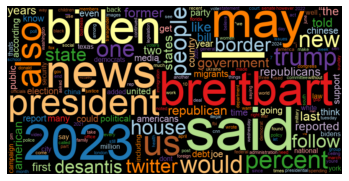

Wordcloud for source: CNN


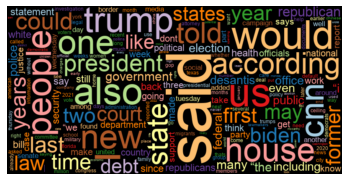

Wordcloud for source: Fox News


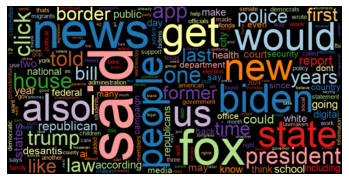

Wordcloud for source: The Washington Post


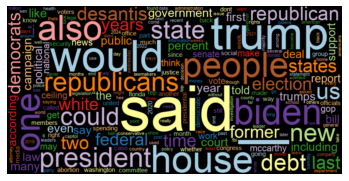

In [11]:
# Iterate and produce word cloud by source
for name, group in master_df.groupby('source_name'):
    print(f"Wordcloud for source: {name}")
    wordcloud(count_words(group)['freq'].to_dict())

## Topic Modeling

In [12]:
# Topic summarization function, from BTAP repo
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1]  # invert sort order
        print('\nTopic %02d' % topic)
        for i in range(0, no_top_words):
            print('  %s (%2.2f)' % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [13]:
# Model topics by source
for source_name, group in master_df.groupby('source_name'):
    print(f'Topic modeling for source: {source_name}')
    
    # Transform article tokens into bag-of-words document-term sparse matrix
    count_vectorizer = CountVectorizer(min_df=0.05, max_df=0.75)
    count_vectors = count_vectorizer.fit_transform(group['article_text_tokenized'])
    print('Vector shape:', count_vectors.shape)

    lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
    W_lda_matrix = lda_model.fit_transform(count_vectors)
    H_lda_matrix = lda_model.components_

    display_topics(lda_model, count_vectorizer.get_feature_names_out())
    print('\n\n')

Topic modeling for source: Breitbart News
Vector shape: (1017, 993)

Topic 00
  percent (4.70)
  trump (4.32)
  desantis (3.02)
  president (2.49)
  republican (1.53)

Topic 01
  biden (1.45)
  house (1.45)
  chinese (1.29)
  china (1.29)
  debt (1.26)

Topic 02
  border (2.80)
  migrants (1.77)
  states (1.32)
  us (1.07)
  state (1.03)

Topic 03
  biden (1.33)
  fbi (1.28)
  report (1.11)
  house (0.98)
  may (0.84)

Topic 04
  people (1.34)
  2023 (1.24)
  may (1.09)
  news (1.01)
  one (0.88)



Topic modeling for source: CNN
Vector shape: (773, 1436)

Topic 00
  state (1.35)
  us (1.32)
  court (1.05)
  law (0.82)
  according (0.81)

Topic 01
  trump (2.99)
  desantis (1.41)
  president (1.29)
  republican (1.20)
  former (1.17)

Topic 02
  party (1.08)
  political (0.87)
  government (0.87)
  years (0.82)
  year (0.80)

Topic 03
  debt (1.42)
  house (1.39)
  would (1.12)
  police (1.05)
  told (0.85)

Topic 04
  people (1.49)
  one (0.95)
  like (0.91)
  border (0.87)
  us (0.85

## TF-IDF. . .

In [14]:
# List of "assumed" political phrases (reality-check?)
political_phrases = ['gun rights', 'voting rights', 'climate change', 'immigration reform',
                     'tax cuts', 'universal healthcare']

# Group master_df by 'source_name' for side-by-side comparison
grouped_df = master_df.groupby('source_name')

# Create dictionary for scores
political_phrase_scores = {}

# Iterate over sources and calc TF-IDF scores vs. political phrases
for source, group in grouped_df:
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
    tfidf_vectors = tfidf_vectorizer.fit_transform(group['article_text_tokenized'])

    # Calc TF-IDF sum (scores) where political phrases found
    scores = {}
    for phrase in political_phrases:
        try:
            index = tfidf_vectorizer.get_feature_names_out().tolist().index(phrase)
            score = tfidf_vectors[:, index].sum()
            scores[phrase] = score
        except ValueError:
            pass

    # Add scores to source total
    political_phrase_scores[source] = scores

# Calc aggregate scores against which to compare "hits" above
all_scores = np.asarray(tfidf_vectors.sum(axis=0)).flatten()
mean_score = np.mean(all_scores)
median_score = np.median(all_scores)

# Iterate over scores and show results
for source_name, scores in political_phrase_scores.items():
    print(f'\nScores for {source_name}:')
    for phrase, score in scores.items():
        relative_to_mean = score / mean_score
        relative_to_median = score / median_score
        print(f'{phrase}: {score:.2f}  -->  {relative_to_mean:.0f} X Mean and {relative_to_median:.0f} X Median')


Scores for Breitbart News:
gun rights: 0.32  -->  7 X Mean and 12 X Median
voting rights: 0.03  -->  1 X Mean and 1 X Median
climate change: 0.95  -->  20 X Mean and 35 X Median
immigration reform: 0.46  -->  10 X Mean and 17 X Median
tax cuts: 0.35  -->  7 X Mean and 13 X Median
universal healthcare: 0.02  -->  1 X Mean and 1 X Median

Scores for CNN:
gun rights: 0.22  -->  5 X Mean and 8 X Median
voting rights: 0.25  -->  5 X Mean and 9 X Median
climate change: 0.45  -->  9 X Mean and 16 X Median
immigration reform: 0.05  -->  1 X Mean and 2 X Median
tax cuts: 0.15  -->  3 X Mean and 5 X Median

Scores for Fox News:
gun rights: 0.82  -->  17 X Mean and 30 X Median
voting rights: 0.97  -->  20 X Mean and 35 X Median
climate change: 1.96  -->  41 X Mean and 72 X Median
immigration reform: 0.73  -->  15 X Mean and 27 X Median
tax cuts: 0.59  -->  12 X Mean and 21 X Median

Scores for The Washington Post:
gun rights: 0.07  -->  1 X Mean and 2 X Median
voting rights: 0.53  -->  11 X Mean